<a href="https://colab.research.google.com/github/shani1610/underwater-object-detection/blob/main/fasterrcnn_on_underwater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Faster-RCNN with underwater dataset

In [1]:
first_time = 1

In [2]:
import os

os.environ['KAGGLE_USERNAME'] = 'sisraelo'
os.environ['KAGGLE_KEY'] = 'b828caf539942769d8cdb923fa1f2e74'

# Verify Kaggle setup
!kaggle datasets list

ref                                                                    title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
bhadramohit/customer-shopping-latest-trends-dataset                    Customer Shopping (Latest Trends) Dataset        76KB  2024-11-23 15:26:12          15728        307  1.0              
hopesb/student-depression-dataset                                      Student Depression Dataset.                     454KB  2024-11-22 17:56:03          12469        161  1.0              
mujtabamatin/air-quality-and-pollution-assessment                      Air Quality and Pollution Assessment             84KB  2024-12-04 15:29:51           6085         96  1.0              
gauthamvijayaraj/spotify-tracks-dataset-updat

In [3]:
if first_time:
  # Download the Underwater Object Detection Dataset
  !kaggle datasets download slavkoprytula/aquarium-data-cots -p /content/aquarium

  # Unzip the dataset
  !unzip -q /content/aquarium/aquarium-data-cots.zip -d /content/aquarium

Dataset URL: https://www.kaggle.com/datasets/slavkoprytula/aquarium-data-cots
License(s): CC0-1.0
 71% 47.0M/66.6M [00:00<00:00, 127MB/s]
100% 66.6M/66.6M [00:00<00:00, 142MB/s]


In [4]:
!pip install torch torchvision matplotlib


In [5]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import torchvision.transforms as T
from PIL import Image
import json

In [6]:
class AquariumDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms
        self.imgs = sorted(os.listdir(images_dir))
        self.labels = sorted(os.listdir(labels_dir))

    @staticmethod
    def yolo_to_fasterrcnn(box, img_width, img_height):
        """
        Converts YOLO format (x_center, y_center, width, height) to Faster R-CNN format (x_min, y_min, x_max, y_max).
        """
        x_center, y_center, width, height = box
        x_min = (x_center - width / 2) * img_width
        y_min = (y_center - height / 2) * img_height
        x_max = (x_center + width / 2) * img_width
        y_max = (y_center + height / 2) * img_height
        return [x_min, y_min, x_max, y_max]

    def __getitem__(self, idx):
        """
        Loads the image and its corresponding annotations.
        Skips images with no annotations.
        """
        img_path = os.path.join(self.images_dir, self.imgs[idx])
        label_path = os.path.join(self.labels_dir, self.labels[idx])

        # Load image
        img = Image.open(img_path).convert("RGB")
        img_width, img_height = img.size

        # Load labels
        boxes = []
        labels = []
        with open(label_path, "r") as f:
            for line in f:
                label = line.strip().split()
                class_id = int(label[0])
                x_center, y_center, width, height = map(float, label[1:])
                boxes.append(self.yolo_to_fasterrcnn([x_center, y_center, width, height], img_width, img_height))
                labels.append(class_id)

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Skip if no annotations
        if len(boxes) == 0:
            return None

        target = {"boxes": boxes, "labels": labels}

        # Apply transforms (if any)
        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
# Define paths
images_dir = '/content/aquarium/aquarium_pretrain/train/images'
labels_dir = '/content/aquarium/aquarium_pretrain/train/labels'

# Transforms
transform = T.Compose([
    T.ToTensor(),
])

# Initialize Dataset
dataset = AquariumDataset(images_dir, labels_dir, transforms=transform)


In [8]:
def custom_collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))  # Remove None entries
    return tuple(zip(*batch))

dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=custom_collate_fn)

In [9]:
# Inspect a batch
for images, targets in dataloader:
    print("Batch Inspection:")
    print("Image shapes:", [img.shape for img in images])  # List of shapes for each image in the batch
    for i, target in enumerate(targets):
        print(f"Target {i}:")
        print("Boxes shape:", target["boxes"].shape)  # Expect shape [N, 4], where N is the number of boxes
        print("Labels shape:", target["labels"].shape)  # Expect shape [N], where N is the number of labels
        print("Boxes:", target["boxes"])  # Optional: to see the actual coordinates
        print("Labels:", target["labels"])  # Optional: to see the actual labels
    break  # Exit after inspecting the first batch

Batch Inspection:
Image shapes: [torch.Size([3, 768, 1024]), torch.Size([3, 1024, 768])]
Target 0:
Boxes shape: torch.Size([12, 4])
Labels shape: torch.Size([12])
Boxes: tensor([[105.5000, 442.0000, 174.5000, 640.0000],
        [638.0000, 490.0000, 678.0000, 672.0000],
        [625.0000, 107.0000, 765.0000, 187.0000],
        [818.0000, 419.0000, 830.0000, 499.0000],
        [810.5000,  23.5000, 941.5000,  80.5000],
        [860.0000, 449.5000, 904.0000, 494.5000],
        [627.0000, 689.5000, 651.0000, 734.5000],
        [893.5000, 514.5000, 942.5000, 559.5000],
        [586.0000, 134.5000, 628.0000, 167.5000],
        [513.5000, 587.0000, 554.5000, 617.0000],
        [465.0000, 406.5000, 503.0000, 431.5000],
        [503.0000, 390.0000, 531.0000, 412.0000]])
Labels: tensor([4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Target 1:
Boxes shape: torch.Size([16, 4])
Labels shape: torch.Size([16])
Boxes: tensor([[167.0000, 486.0000, 561.0000, 658.0000],
        [544.0000, 662.0000, 634.0000, 736.00

In [10]:
for idx in range(10):
    image, target = dataset[idx]
    print(f"Image {idx}:")
    print("Boxes:", target["boxes"])
    print("Labels:", target["labels"])

Image 0:
Boxes: tensor([[  79.5000,  447.0000,  340.5000,  597.0000],
        [ 577.0000,  591.5000,  767.0000,  720.5000],
        [ 426.0000,  262.0000,  582.0000,  374.0000],
        [   0.0000,  282.0000,  252.0000,  394.0000],
        [ 304.5000,  400.5000,  523.5000,  507.5000],
        [ 211.5000,  167.0000,  484.5000,  269.0000],
        [ 295.5000,  245.5000,  494.5000,  346.5000],
        [  85.5000,  764.0000,  288.5000,  864.0000],
        [ 405.0000,   44.5000,  673.0000,  143.5000],
        [ 209.5000,  749.5000,  456.5000,  844.5000],
        [ 566.5000,  125.0000,  767.5000,  219.0000],
        [ 547.0000,  815.0000,  767.0000,  905.0000],
        [ 538.5000,  461.5000,  767.5000,  548.5000],
        [   3.5000,  653.0000,  230.5000,  737.0000],
        [ 469.0000,  668.5000,  659.0000,  747.5000],
        [ 614.5000,  362.0000,  767.5000,  440.0000],
        [   0.0000,  911.0000,   75.0000,  989.0000],
        [ 222.5000,  782.5000,  445.5000,  857.5000],
        [ 35

load test and val dataloader

In [34]:
# Define paths
images_val_dir = '/content/aquarium/aquarium_pretrain/valid/images'
labels_val_dir = '/content/aquarium/aquarium_pretrain/valid/labels'

# Transforms
transform = T.Compose([
    T.ToTensor(),
])

# Initialize Dataset
dataset_val = AquariumDataset(images_val_dir, labels_val_dir, transforms=transform)

def custom_collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))  # Remove None entries
    return tuple(zip(*batch))

val_dataloader = DataLoader(dataset_val, batch_size=2, shuffle=True, collate_fn=custom_collate_fn)


In [35]:
# Define paths
images_test_dir = '/content/aquarium/aquarium_pretrain/test/images'
labels_test_dir = '/content/aquarium/aquarium_pretrain/test/labels'

# Transforms
transform = T.Compose([
    T.ToTensor(),
])

# Initialize Dataset
dataset_test = AquariumDataset(images_test_dir, labels_test_dir, transforms=transform)

def custom_collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))  # Remove None entries
    return tuple(zip(*batch))

test_dataloader = DataLoader(dataset_test, batch_size=2, shuffle=True, collate_fn=custom_collate_fn)

Load Pretrained Faster R-CNN and Modify for Fine-tuning

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 118MB/s]


In [12]:
%pip install torchinfo


In [23]:
from torchinfo import summary
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define a wrapper for Faster R-CNN to accept a single tensor batch
class FasterRCNNWrapper(torch.nn.Module):
    def __init__(self, model):
        super(FasterRCNNWrapper, self).__init__()
        self.model = model

    def forward(self, images, targets=None):
        """
        Forward method that passes images and targets to the wrapped model.
        """
        if self.training:
            # During training, return the loss dictionary
            return self.model(images, targets)
        else:
            # During inference, return predictions
            return self.model(images)

# Load Faster R-CNN model
fasterrcnn = fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the box predictor to adjust the number of classes
num_classes = 8  # 7 classes + 1 background
in_features = fasterrcnn.roi_heads.box_predictor.cls_score.in_features  # Get the number of input features
fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)  # Replace with new predictor

# Wrap the model
model = FasterRCNNWrapper(fasterrcnn).to("cuda")
model.eval()  # Set model to evaluation mode

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze specific layers
for param in model.model.roi_heads.box_predictor.parameters():  # Access the underlying model
    param.requires_grad = True

# Create a dummy input batch (batch_size=2)
dummy_images = torch.rand(2, 3, 224, 224).to("cuda")  # Batch of images

# Use torchinfo to print the model summary
summary(
    model=model,
    input_data=dummy_images,  # Pass the batch as a single tensor
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
FasterRCNNWrapper (FasterRCNNWrapper)                        [2, 3, 224, 224]     [100, 4]             --                   Partial
├─FasterRCNN (model)                                         [2, 3, 224, 224]     [100, 4]             --                   Partial
│    └─GeneralizedRCNNTransform (transform)                  [2, 3, 224, 224]     [2, 3, 800, 800]     --                   --
│    └─BackboneWithFPN (backbone)                            [2, 3, 800, 800]     [2, 256, 13, 13]     --                   False
│    │    └─IntermediateLayerGetter (body)                   [2, 3, 800, 800]     [2, 2048, 25, 25]    (23,454,912)         False
│    │    └─FeaturePyramidNetwork (fpn)                      [2, 256, 200, 200]   [2, 256, 13, 13]     (3,344,384)          False
│    └─RegionProposalNetwork (rpn)                           [2, 3, 800, 800]     [10

In [24]:
# Optimizer and Learning Rate
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training Device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

FasterRCNNWrapper(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

Training Loop

In [25]:
import torch
from torch.utils.data import DataLoader

# Parameters
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=1e-4)

# Learning rate scheduler (optional)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0
    for images, targets in dataloader:
        # Move data to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Step the scheduler
    lr_scheduler.step()

    # Log the epoch loss
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Training complete!")

Epoch 1/20, Loss: 249.4001
Epoch 2/20, Loss: 187.2063
Epoch 3/20, Loss: 175.0333
Epoch 4/20, Loss: 167.9220
Epoch 5/20, Loss: 167.3394
Epoch 6/20, Loss: 166.1998
Epoch 7/20, Loss: 165.8572
Epoch 8/20, Loss: 167.2203
Epoch 9/20, Loss: 165.0628
Epoch 10/20, Loss: 165.3573
Epoch 11/20, Loss: 165.7998
Epoch 12/20, Loss: 165.7337
Epoch 13/20, Loss: 165.6505
Epoch 14/20, Loss: 165.5937
Epoch 15/20, Loss: 165.2141
Epoch 16/20, Loss: 169.3273
Epoch 17/20, Loss: 164.9859
Epoch 18/20, Loss: 165.9932
Epoch 19/20, Loss: 164.7141
Epoch 20/20, Loss: 165.5529
Training complete!


Perform Inference

In [26]:
# Switch model to evaluation mode
model.eval()

# Inference on a batch of images
with torch.no_grad():
    for images, _ in dataloader:  # During inference, we don't need targets
        images = [img.to(device) for img in images]

        # Forward pass (no targets needed during inference)
        predictions = model(images)

        # Process predictions
        for i, prediction in enumerate(predictions):
            print(f"Image {i} Predictions:")
            print("Boxes:", prediction["boxes"])  # Bounding boxes
            print("Labels:", prediction["labels"])  # Class labels
            print("Scores:", prediction["scores"])  # Confidence scores
        break  # Remove this if you want to iterate over the entire dataset

Image 0 Predictions:
Boxes: tensor([[ 399.5058,  135.9392,  759.0928,  593.0452],
        [ 661.1755,   20.8158,  768.0000,  159.8278],
        [ 405.2155,  351.9710,  729.1431,  539.3370],
        [ 393.5512,  486.8912,  488.9341,  530.2217],
        [ 652.0021,   15.0225,  768.0000,  159.0602],
        [ 138.3173,  618.8648,  465.4565, 1001.1077],
        [ 650.8303,   13.5046,  765.7136,  179.4920],
        [ 401.5376,  152.3268,  754.7437,  552.5289],
        [  29.2842,  124.8822,  760.7360,  237.9971],
        [ 131.8492,  439.0667,  344.5805,  520.9691],
        [ 141.3902,  649.9170,  471.3269, 1002.2779],
        [ 411.8943,  319.5354,  727.1932,  531.5068],
        [ 146.7818,  642.1118,  448.4317, 1008.8171]], device='cuda:0')
Labels: tensor([4, 1, 4, 1, 6, 6, 4, 2, 4, 4, 4, 2, 5], device='cuda:0')
Scores: tensor([0.1154, 0.0978, 0.0866, 0.0821, 0.0765, 0.0718, 0.0693, 0.0667, 0.0578,
        0.0524, 0.0523, 0.0521, 0.0504], device='cuda:0')
Image 1 Predictions:
Boxes: tenso

In [37]:
import matplotlib.pyplot as plt
import cv2


# Function to visualize image with bounding boxes
def plot_image_with_boxes(image, boxes, labels=None, scores=None, title=None):
    """Visualize image with bounding boxes."""
    image = to_pil_image(image.cpu())
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box.cpu()
        color = 'r' if (labels is None or labels[i] == 0) else 'g'
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color=color, linewidth=2)
        ax.add_patch(rect)
        label_text = f'{labels[i]}' if labels is not None else ""
        if scores is not None:
            label_text += f" ({scores[i]:.2f})"
        plt.text(x_min, y_min - 5, label_text, color=color, fontsize=12)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [30]:
from torchvision.transforms.functional import to_pil_image
from torchvision.ops.boxes import box_iou
from tqdm import tqdm

In [28]:
def evaluate_model(model, dataloader, device="cuda"):
    """Evaluate model performance."""
    model.eval()
    precision_list, recall_list, average_precisions = [], [], []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            for i, output in enumerate(outputs):
                gt_boxes = targets[i]["boxes"]
                pred_boxes = output["boxes"]
                pred_scores = output["scores"]

                # Compute IoU
                iou_matrix = box_iou(pred_boxes, gt_boxes)

                # Calculate Precision/Recall (IoU threshold = 0.5)
                iou_threshold = 0.5
                matches = iou_matrix > iou_threshold
                tp = matches.sum().item()  # True Positives
                fp = len(pred_boxes) - tp  # False Positives
                fn = len(gt_boxes) - tp   # False Negatives

                precision = tp / (tp + fp + 1e-6)
                recall = tp / (tp + fn + 1e-6)
                precision_list.append(precision)
                recall_list.append(recall)

                # Average Precision
                average_precisions.append(precision * recall)

    # Calculate Mean Metrics
    precision_mean = sum(precision_list) / len(precision_list)
    recall_mean = sum(recall_list) / len(recall_list)
    mAP = sum(average_precisions) / len(average_precisions)

    print(f"Precision: {precision_mean:.4f}")
    print(f"Recall: {recall_mean:.4f}")
    print(f"mAP: {mAP:.4f}")
    return precision_mean, recall_mean, mAP

In [39]:
def visualize_predictions(model, dataloader, device="cuda"):
    """Visualize predictions vs. ground truth."""
    model.eval()
    counter = 0
    with torch.no_grad():
        for images, targets in dataloader:
            counter += 1
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            for i, image in enumerate(images):
                pred_boxes = outputs[i]["boxes"]
                pred_scores = outputs[i]["scores"]
                gt_boxes = targets[i]["boxes"]

                # Plot predictions (in red) and ground truth (in green)
                plot_image_with_boxes(image, pred_boxes, scores=pred_scores, title="Predictions")
                plot_image_with_boxes(image, gt_boxes, title="Ground Truth")
                break  # Visualize first image only
            if counter > 4:
              break  # Visualize first batch only

Evaluating: 100%|██████████| 64/64 [00:18<00:00,  3.47it/s]


Precision: 0.3974
Recall: 2.9841
mAP: 1.2619


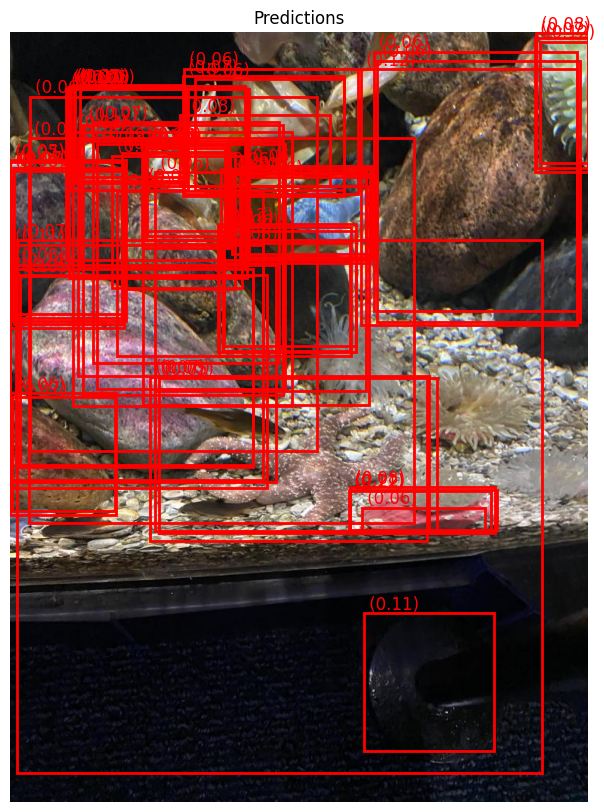

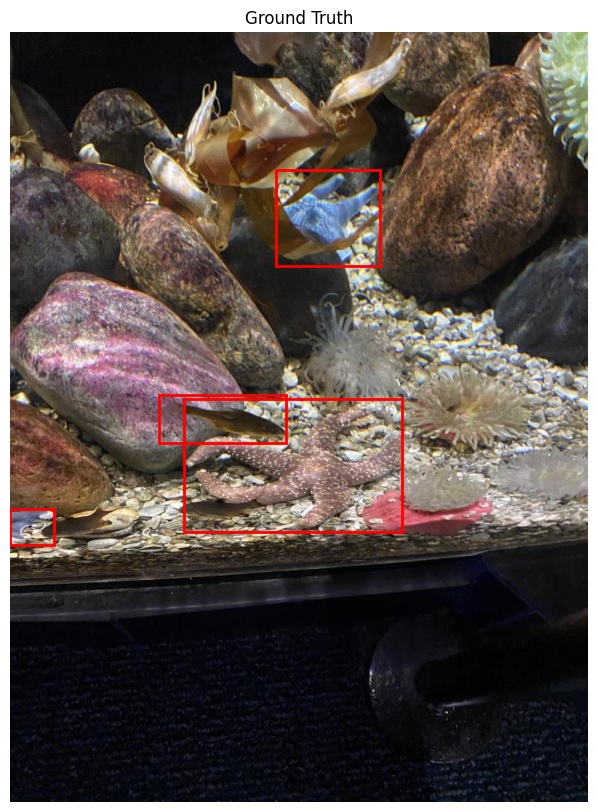

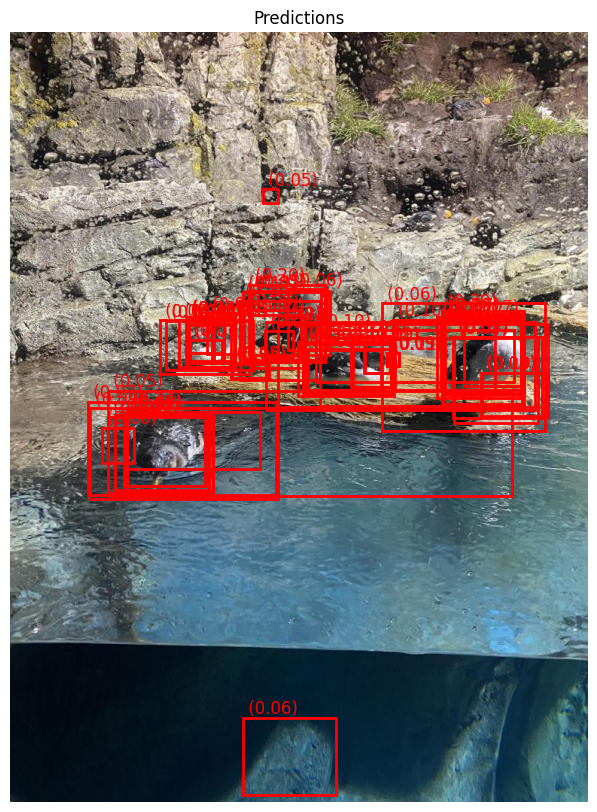

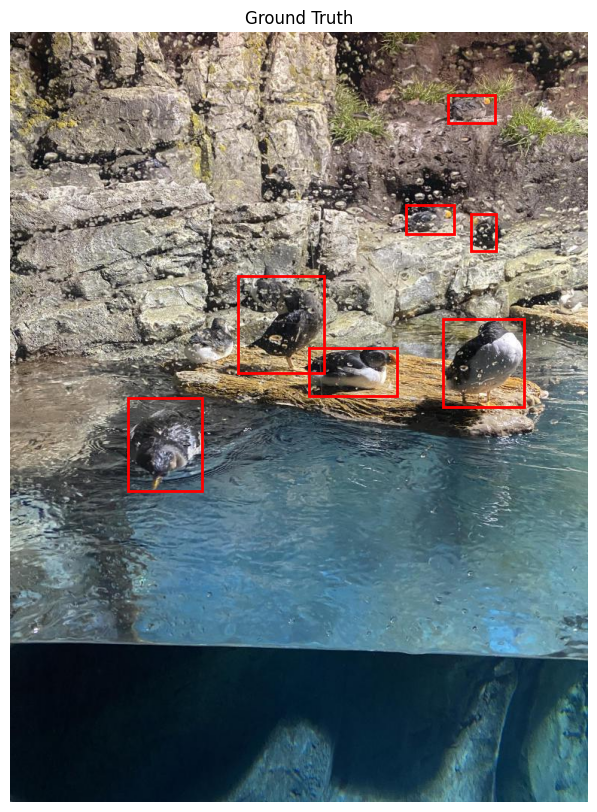

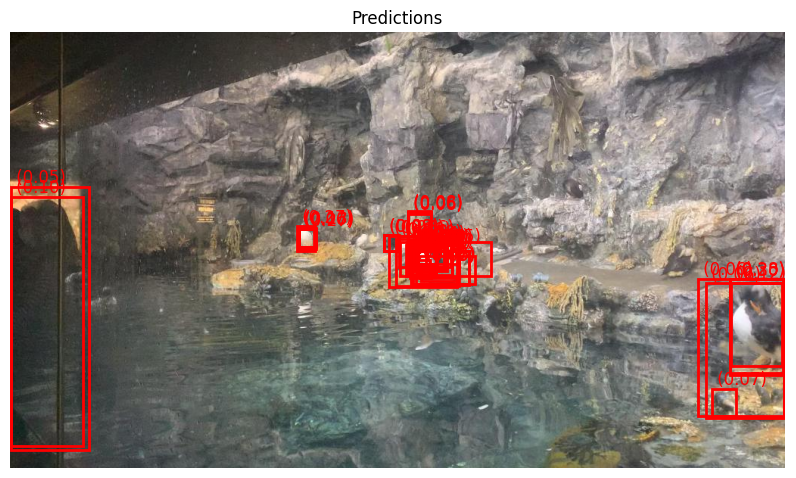

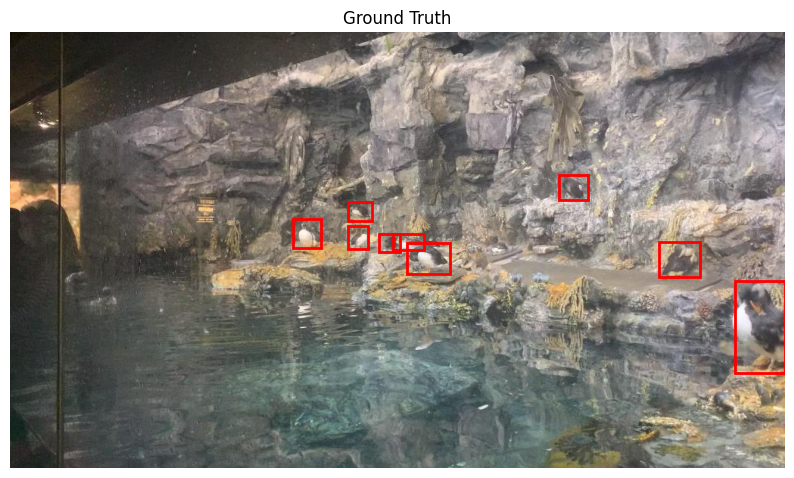

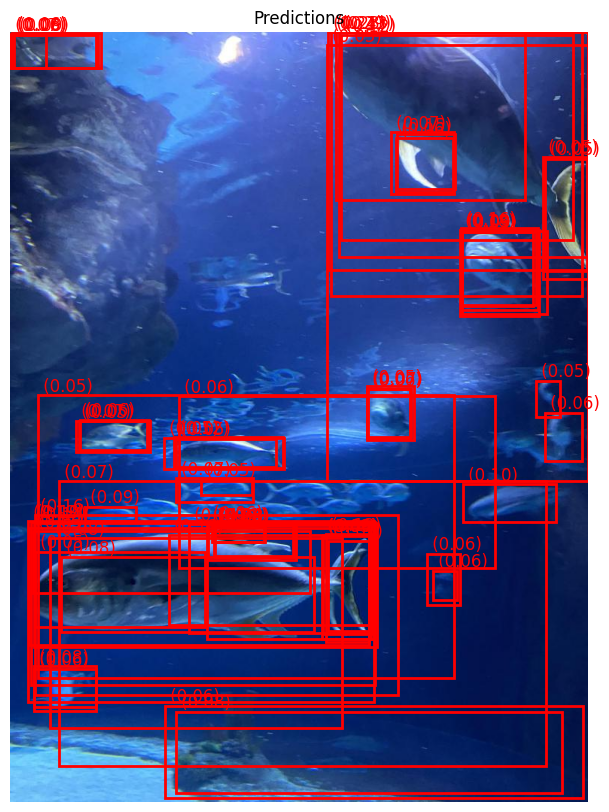

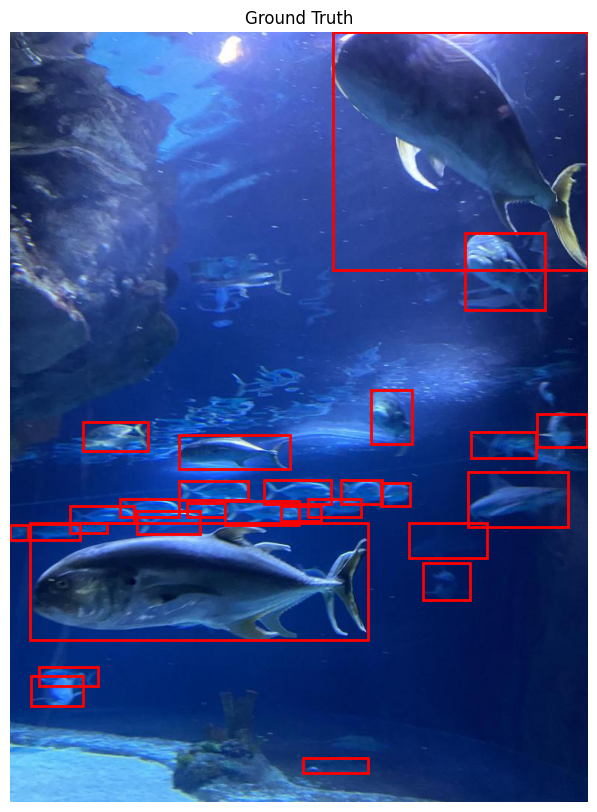

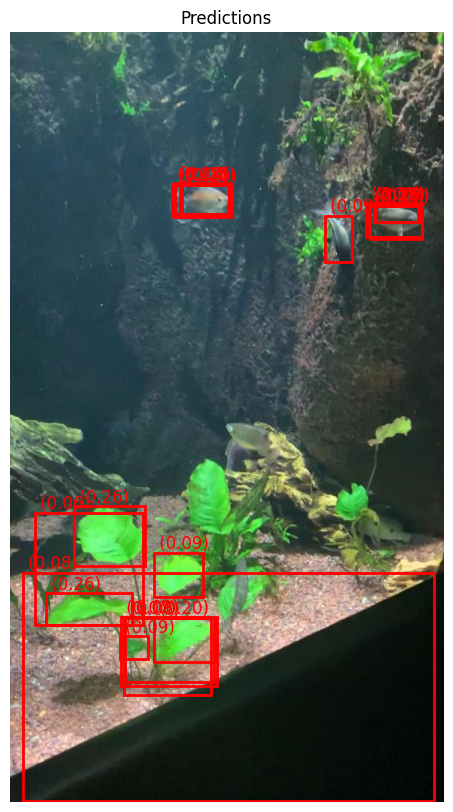

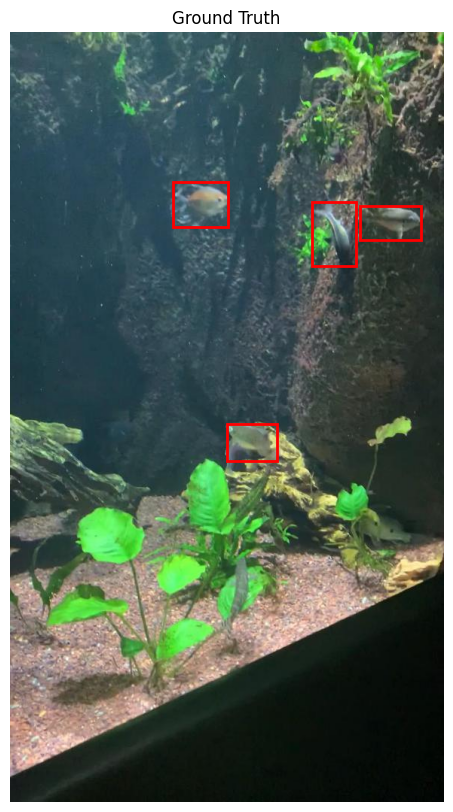

In [40]:
# Assuming `val_loader` is your validation dataloader
precision, recall, mAP = evaluate_model(model, val_dataloader)

# Visualize predictions
visualize_predictions(model, val_dataloader)

Save the Model

In [41]:
torch.save(model.state_dict(), "fasterrcnn_resnet50_aquarium.pth")
